# Import Modules

In [2]:
pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.8 MB 4.8 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.8 MB 4.8 MB/s eta 0:00:02
   ------------ --------------------------- 3.1/9.8 MB 4.9 MB/s eta 0:00:02
   ---------------- ----------------------- 3.9/9.8 MB 4.9 MB/s eta 0:00:02
   -------------------- ------------------- 5.0/9.8 MB 4.9 MB/s eta 0:00:01
   ------------------------ --------------- 6.0/9.8 MB 4.9 MB/s eta 0:00:01
   ----------------------------- ---------- 7.3/9.8 MB 4.9 MB/s eta 0:00:01
   ---------------------------------- ----- 8.4/9.8 MB 4.9 MB/s eta 0:00:01
   ------------------------------------- -- 9.2/9.8 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 4.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# load the Dataset

In [6]:
df = pd.read_csv('AirPassengers.csv')
df.set_index('Month',inplace=True)
df.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


# EDA

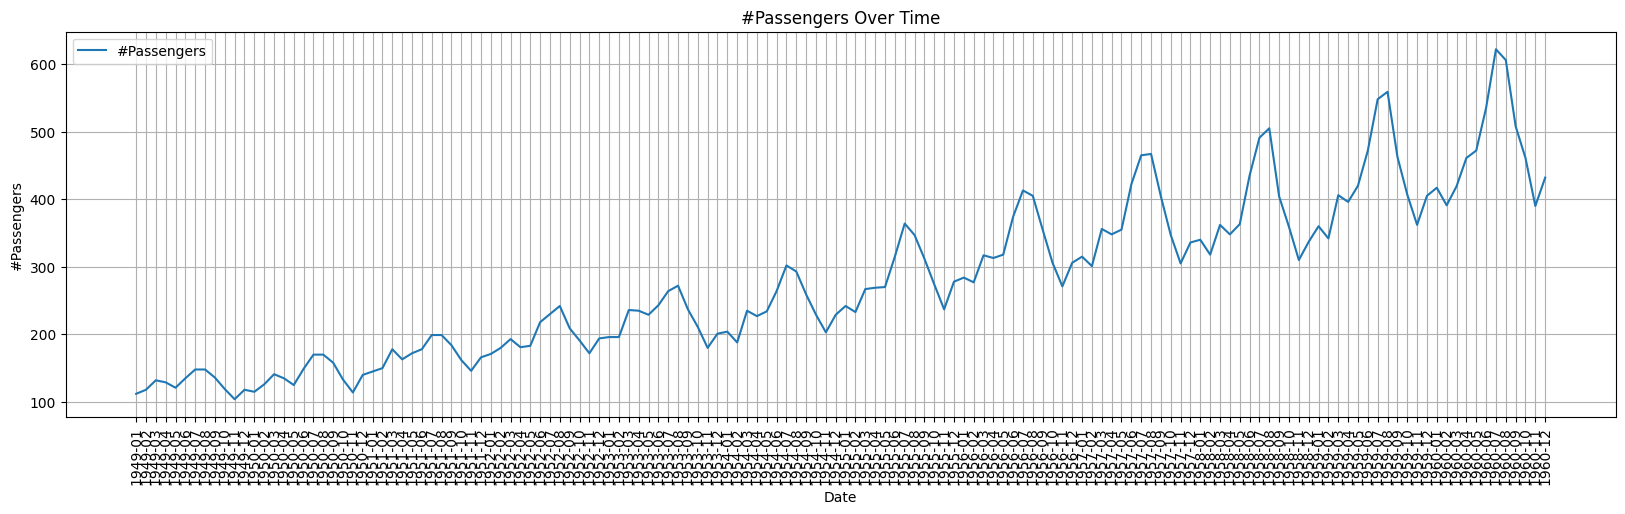

In [8]:
plt.figure(figsize=(20,5))
plt.plot(df.index,df['#Passengers'],label='#Passengers')
plt.xlabel('Date')
plt.ylabel('#Passengers')
plt.title('#Passengers Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

# perform seasonal decomposition

In [13]:
result = seasonal_decompose(df['#Passengers'],model='multiplicative',period=12)

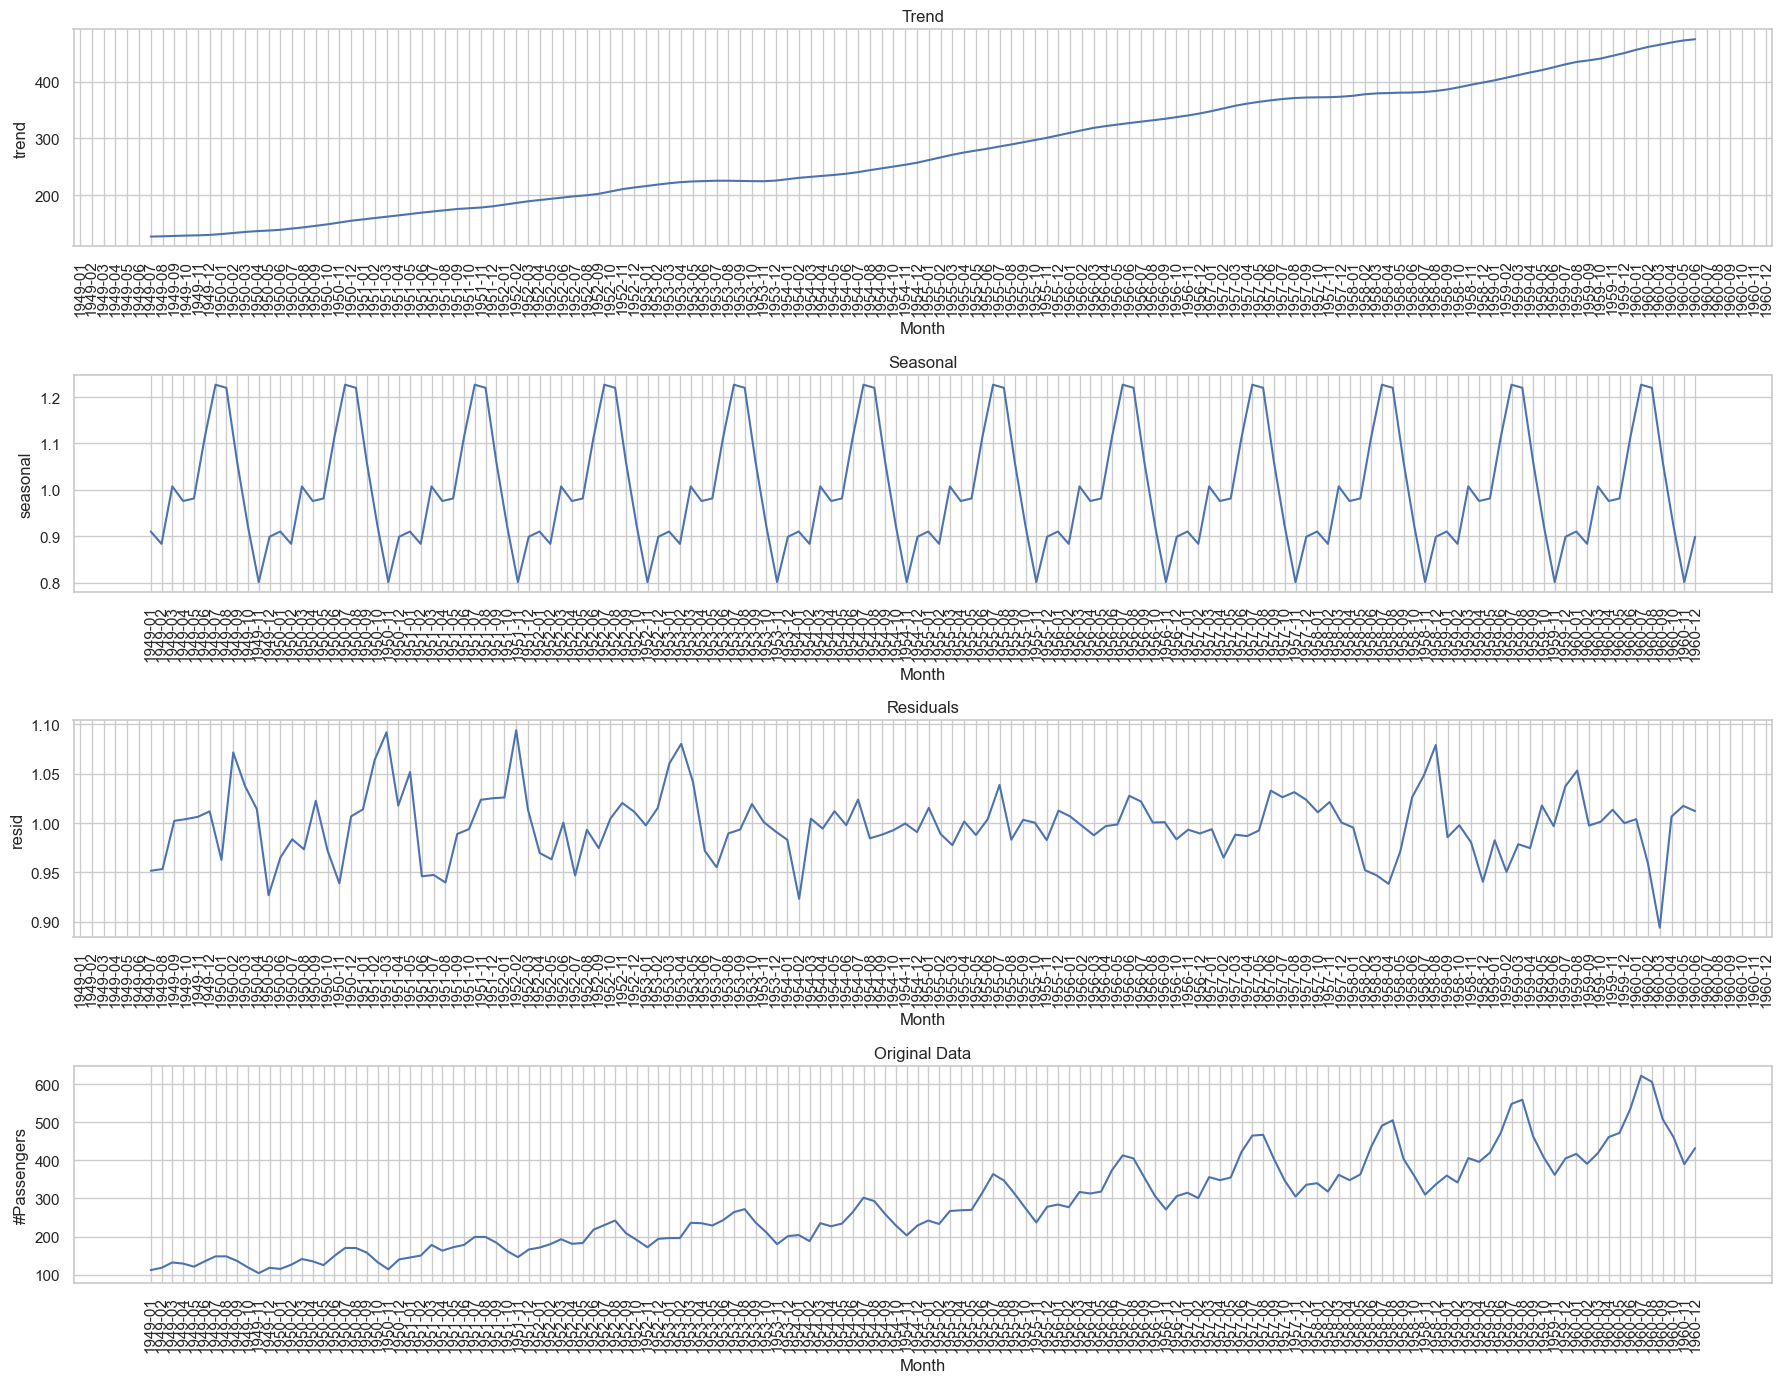

In [15]:
# plot the componrents in the graph
sns.set(style='whitegrid')

plt.figure(figsize=(18,14))

# trend component
plt.subplot(411)
sns.lineplot(data=result.trend)
plt.title('Trend')
plt.xticks(rotation=90)

# seasonal component
plt.subplot(412)
sns.lineplot(data=result.seasonal)
plt.title('Seasonal')
plt.xticks(rotation=90)


# Residuals component
plt.subplot(413)
sns.lineplot(data=result.resid)
plt.title('Residuals')
plt.xticks(rotation=90)

# Original component
plt.subplot(414)
sns.lineplot(data=df['#Passengers'])
plt.title('Original Data')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [49]:
seasonal_period = 12

In [18]:
from statsmodels.tsa.stattools import adfuller  # Augumented Dickey-Fuller Test

result = adfuller(df['#Passengers'],autolag='AIC')  # Akaike Information Criterion
print('ADF Statistic:',result[0])
print('p-value:',result[1])

ADF Statistic: 0.8153688792060463
p-value: 0.991880243437641


In [19]:
# first order differencing
result = adfuller(df['#Passengers'].diff().dropna(),autolag='AIC') 
print('ADF Statistic:',result[0])
print('p-value:',result[1])

ADF Statistic: -2.8292668241699923
p-value: 0.054213290283826474


In [20]:
# second order differencing
result = adfuller(df['#Passengers'].diff().diff().dropna(),autolag='AIC') 
print('ADF Statistic:',result[0])
print('p-value:',result[1])

ADF Statistic: -16.384231542468516
p-value: 2.7328918500141235e-29


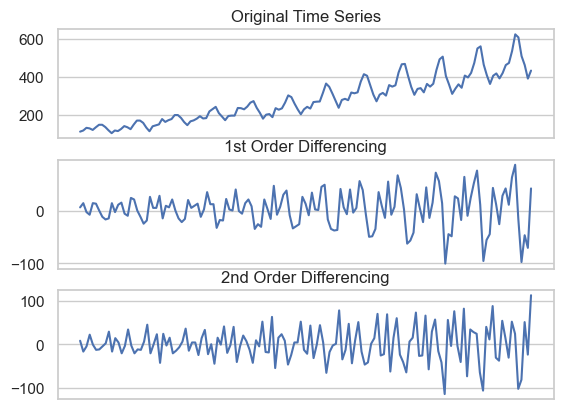

In [22]:
# Plot the differencing values
fig, (ax1,ax2,ax3) = plt.subplots(3)

ax1.plot(df)
ax1.set_title('Original Time Series')
ax1.axes.xaxis.set_visible(False)

ax2.plot(df.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)

ax3.plot(df.diff().diff())
ax3.set_title('2nd Order Differencing')
ax3.axes.xaxis.set_visible(False)

plt.show()



In [ ]:
# The time series become stationary after first order differencing

## Define Parameters for ARIMA

In [23]:
# p = 0  # MA -Moving Average
# d = 1  # order of differencing
# q = 0 # AR - Auto Regressive

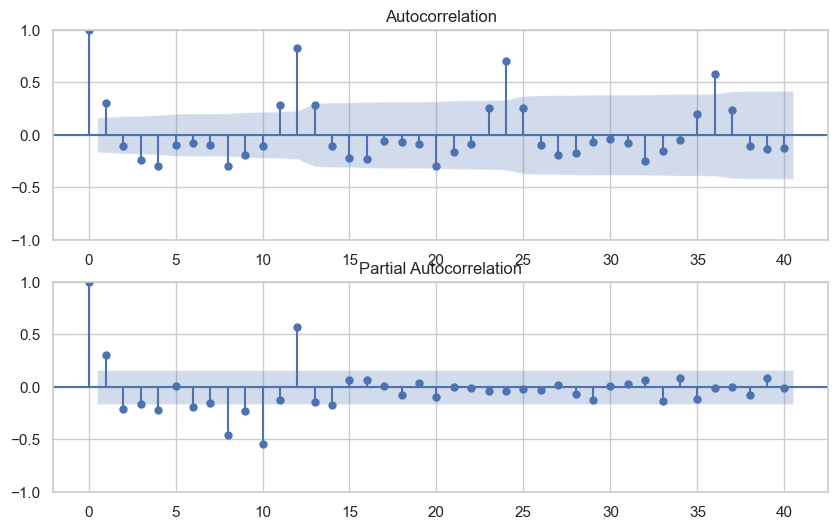

In [28]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
sm.graphics.tsa.plot_acf(df.diff().dropna(), lags=40,ax=ax[0])
sm.graphics.tsa.plot_pacf(df.diff().dropna(), lags=40,ax=ax[1])
plt.show()

In [29]:
p = 2   # pacf
d = 1    # 1st order differening
q = 1   # acf

In [50]:
P  = 1
D  = 0
Q  = 3

# Model Training

In [51]:
# define the ARIMA Models

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['#Passengers'],order=(p,d,q),seasonal_order=(P,D,Q,seasonal_period))
fitted_model = model.fit()
print(fitted_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                #Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2, 3], 12)   Log Likelihood                -563.224
Date:                                    Tue, 20 May 2025   AIC                           1142.448
Time:                                            12:17:50   BIC                           1166.151
Sample:                                        01-01-1949   HQIC                          1152.080
                                             - 12-01-1960                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6249      0.101      6.168      0

# Forecasting

In [52]:
# forecast for next 2 years

forecast_steps = 24
forecast = fitted_model.get_forecast(steps=forecast_steps)

# create the date range for the forecasted values
forecast_index = pd.date_range(start=df.index[-1],periods=forecast_steps+1,freq='M')[1:].strftime('%Y-%m') # remove start date 

In [53]:
# Create a forecast dataframe

forecast_df = pd.DataFrame({
    "Forecast": list(forecast.predicted_mean),
    "Lower CI": list(forecast.conf_int().iloc[:,0]),
    "Upper CI": list(forecast.conf_int().iloc[:,1])
}, index=forecast_index)

forecast_df.head()

,Forecast,Lower CI,Upper CI
1961-01,446.725709,424.884062,468.567355
1961-02,423.353836,397.213446,449.494227
1961-03,456.483003,426.866429,486.099576
1961-04,491.586477,459.556686,523.616269
1961-05,505.163387,471.286406,539.040368


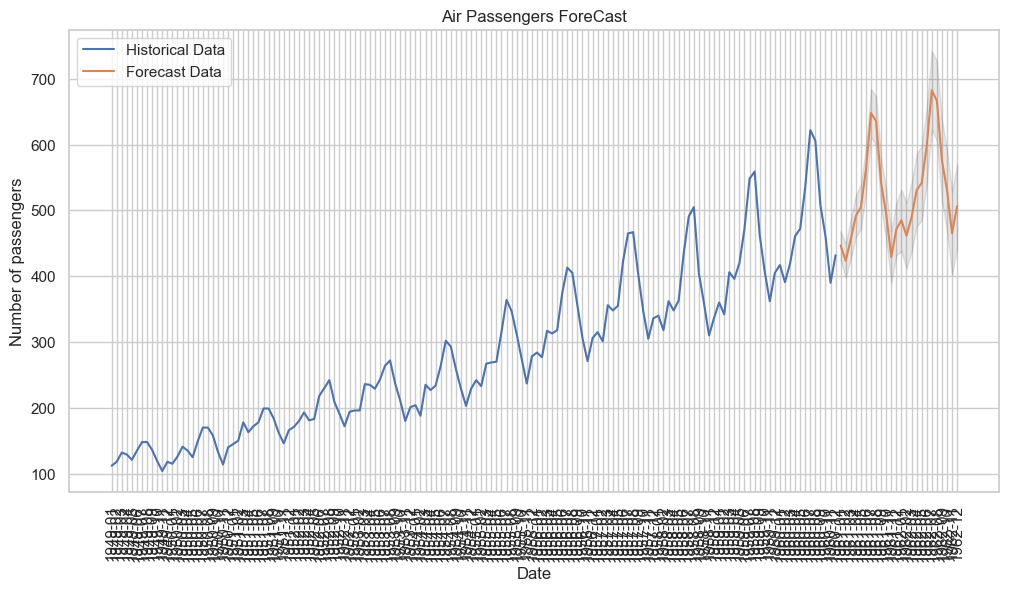

In [54]:
# plot the forecast values

plt.figure(figsize=(12,6))
plt.plot(df['#Passengers'],label="Historical Data")
plt.plot(forecast_df['Forecast'],label = 'Forecast Data')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='k',alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.title('Air Passengers ForeCast')
plt.xticks(rotation=90)
plt.legend()
plt.show()